# Monte Carlo Nullpoint Approach - Code Description

This is the central code for looking at nullpoints under a Jupyter Notebooks framework

This is the python script for replicating the Bi,Spencer 2D stabilization technique with the intention of varying TI for Eq.3 to observe the TI related nullpoint - this code has the potential to look at a histogram for each TI value or to look at the standard deviation across the population for a range of TI values

# Import Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
# import mpld3
# mpld3.enable_notebook()

#New import: Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process
#Followed by: .venv\scripts\activate

# Set Options

In [2]:
#Initial Options
histPlot = True
stdPlot = True
cNPlot = True

# Initialize Parameters and Arrays

In [3]:
#Assumed echo time points
TE_array = np.arange(8, 513, 8) #ms units
TI_array = np.linspace(2,4,5) 
TI_array = 10**TI_array #ms units

#Parameters that dictate process related features
iterCount = 10000 #number of iterations that curveFit is applied
SNR = 1000

######All Fixed parameters for code
#Parameters held constant
c1 = 0.4
c2 = 0.5
T21 = 45
T22 = 100
T11 = 600
T12 = 1200

initParams = np.array([T11, T12, c1, c2, T21, T22])

#Bound used during NLLS to constrain the upper bound on T2 values
T1_bound = 2000
T2_bound = 1000

#Zoom Fits range
rad = 0.05 #percent radius around the zoom fits

#Preparing TI array to loop through
TI1star = np.log(2)*(T11)
TI2star = np.log(2)*T12

#Initializing all the storage matrices
#Storing all strings associated with titles
paramTitle_np = ['c1', 'c2', 'T21', 'T22']
paramTitle_6p = ['T11','T12','c1','c2','T21','T22']

round_Params = [round(num, 2) for num in initParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in paramTitle_6p) #Builds the list of parametes used to generate the original data

#Initializing where all parameter values are stored
paramStore_6p = np.zeros([iterCount, np.size(paramTitle_6p)])
paramStore_np = np.zeros([iterCount, np.size(paramTitle_np)])

#Storing all the estimated signals for each iteration and TI array
sigStore_6p = np.zeros([iterCount, np.size(TE_array), np.size(TI_array)])
sigStore_np = np.zeros([iterCount, np.size(TE_array), np.size(TI_array)])

#All standard deviation of parameter values matrices
paramStd_6p = np.zeros([iterCount, np.size(paramTitle_6p)])
paramStd_np = np.zeros([iterCount, np.size(paramTitle_np)])

#All error related matrices
RSS_6p = np.zeros([iterCount])
errStore_6p = np.zeros([iterCount])
RSS_np = np.zeros([iterCount])
errStore_np = np.zeros([np.size(TI_array),iterCount])

#Time to Compute
ttC_6p = 0
ttC_np = 0

#Condition number related matrix
# CNStore = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle_6p)])
# avgCNStore = np.zeros([np.size(TI_array), np.size(ParamTitle_6p)])

#Count Rulebreakers
numRuleBreak = np.zeros(np.size(TI_array))

#Title String
details = str('\nTI1* = ' + str(round(TI1star,2)) + ' : TI2* = ' + str(round(TI2star,2)) +" :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
            '\nTE Range (' + str(TE_array[0]) + "," + str(TE_array[np.size(TE_array)-1]) +
            '):: Points: ' + str(np.size(TE_array)) +
            '\nTI Exp Range (' + str(np.log10(TI_array[0])) + "," + str(np.log10(TI_array[np.size(TI_array)-1])) +
            '):: Points: ' + str(np.size(TI_array)))

# Define Functions

In [4]:
#Defining the function of interest
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#This is necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, T11, T12, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def S_moX_3p(TE, TI, T1, c, T2):
    return c*(1-2*np.exp(-TI/T1))*np.exp(-TE/T2)

#Function for calculating the d coeficient for a TI, c, T1 collection
def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def add_noise(SNR,dat):
    noiseSigma = np.max(np.abs(dat))/SNR
    noise = np.random.normal(0,noiseSigma,dat.shape)
    return dat + noise

def Jacobian_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    #Returns the Jacobian of our 6 parameter, 2D problem
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dc1, dc2, dT11, dT12, dT21, dT22), axis = -1)
    return jacobian

def Jacobian_4p(TE, d1, d2, T21, T22):
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

# Build Curve Fitting Dataset

In [5]:
#Looping through iterations in building the parameter sets

for iter in trange(iterCount):
    
    #monoexponential method
    np_data = S_biX_6p(TE_array,TI1star,*initParams) #Generate the true nullpoint data
    np_noised = add_noise(SNR,np_data)

    mTE, mTI = np.meshgrid(TE_array,TI_array)
    mS = S_biX_6p(mTE,mTI,*initParams)
    mS_noised = add_noise(SNR,mS)

    vecT = np.vstack((mTE.ravel(), mTI.ravel())) #flattens the data points
    vecS = mS_noised.ravel()

    start = time.perf_counter()

    init_p = [c2,T22]
    lb = (-1,0)
    ub = (1,T2_bound)

    # popt_np1, pcov_np1 = curve_fit(lambda t_dat,est_c2,est_T22 : S_moX_2p(t_dat,est_c2,est_T22), TE_series, np_noised, p0 = init_p, bounds = [lb,ub]) 
    popt_np1, pcov_np1 = curve_fit(lambda t_dat,est_c2,est_T22 : S_moX_3p(t_dat, TI1star, T12, est_c2, est_T22), TE_array, np_noised, p0 = init_p, bounds = [lb,ub])
    
    p_c2, p_T22 = popt_np1

    init_p = [c1, T21]
    lb = (-1,0)
    ub = (1,T2_bound)

    popt_np_All, pcov_np_All = curve_fit(lambda t_dat,est_c1,est_T21 : S_biX_6p_ravel(t_dat, T11, T12, est_c1, p_c2, est_T21, p_T22), vecT, vecS, p0 = init_p, bounds = [lb,ub])

    ttC_np = ttC_np + (time.perf_counter() - start)

    #collecting all parameters estimated via the nullpoint method
    popt_np = (popt_np_All[0], p_c2, popt_np_All[1], p_T22)

    paramStore_np[iter,:] = popt_np

    start = time.perf_counter()

    init_p = [T11, T12, c1, c2, T21, T22]
    lb = (0,0,-1,-1,0,0)
    ub = (T1_bound,T1_bound,1,1,T2_bound,T2_bound)

    popt_6p, pcov_6p = curve_fit(lambda t_dat, e_T11, e_T12, e_c1, e_c2, e_T21, e_T22 : S_biX_6p_ravel(t_dat, e_T11, e_T12, e_c1, e_c2, e_T21, e_T22), vecT, vecS, p0 = init_p, bounds = [lb,ub])

    ttC_6p = ttC_6p + (time.perf_counter() - start)

    if (popt_6p[5] < popt_6p[4]): #We want by convention to make sure that T22 is larger than T21
        p_hold = popt_6p[0]
        popt_6p[0] = popt_6p[1]
        popt_6p[1] = p_hold
        p_hold = popt_6p[2]
        popt_6p[2] = popt_6p[3]
        popt_6p[3] = p_hold
        p_hold = popt_6p[4]
        popt_6p[4] = popt_6p[5]
        popt_6p[5] = p_hold

    paramStore_6p[iter,:] = popt_6p

    est_Sig = S_biX_6p(mTE,mTI,T11,T12,*popt_np)
    RSS_np[iter] = np.sum((mS - est_Sig)**2)
    sigStore_np[iter,:,:] = est_Sig.T

    est_Sig = S_biX_6p(mTE,mTI,*popt_6p)
    RSS_np[iter] = np.sum((mS - est_Sig)**2)
    sigStore_np[iter,:,:] = est_Sig.T

100%|██████████| 10000/10000 [01:42<00:00, 97.27it/s]


# Plotting

### Histogram of Parameters

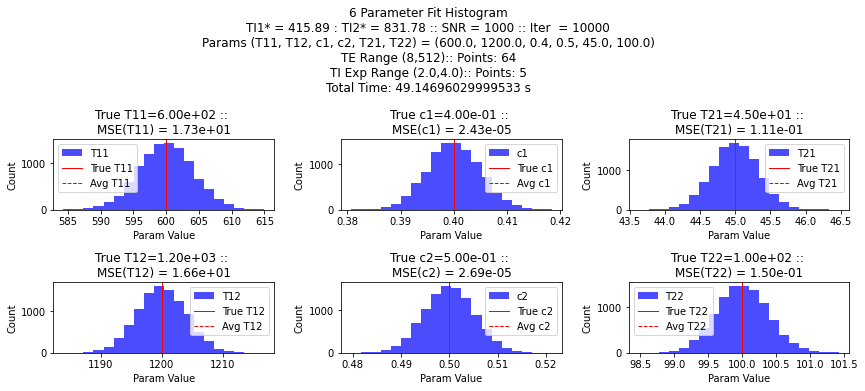

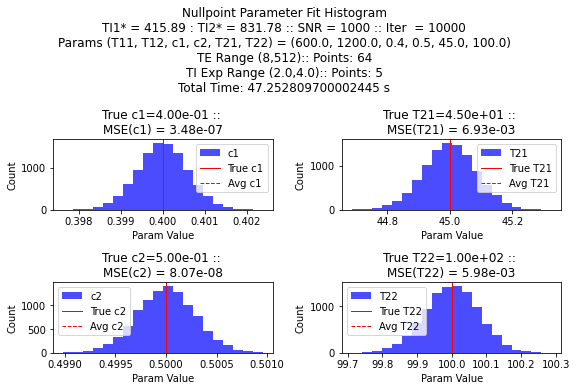

In [10]:
if histPlot:
    fig, ax = plt.subplots(2,paramStore_6p.shape[1]//2, figsize=(12,5.5), tight_layout=True)
    fig.suptitle("6 Parameter Fit Histogram" + details + '\nTotal Time: ' + str(ttC_6p) + ' s')

    varMat = np.var(paramStore_6p,axis=0)
    biMat = np.mean(paramStore_6p,axis=0) - initParams
    MSEMat = varMat + biMat**2
    
    for ii in range(paramStore_6p.shape[1]):
        #Construct a nice figure of each of the two 
        ax[ii%2,ii//2].hist(x=paramStore_6p[:,ii], bins=20, color='b', label = paramTitle_6p[ii], alpha = 0.7)
        # ax[ii].hist(x=paramStore_6p[:,2*ii+1], bins=20, color='g', label = paramTitle_6p[2*ii+1], alpha = 0.7)
        ax[ii%2,ii//2].set_xlabel('Param Value')
        ax[ii%2,ii//2].set_ylabel('Count')
        ax[ii%2,ii//2].axvline(x=initParams[ii], linewidth=1, label= 'True ' + paramTitle_6p[ii], color='red')
        # ax[ii%2,ii//2].axvline(x=initParams[ii+1], linewidth=1, label= 'True ' + paramTitle_6p[ii+1], color='orange')
        ax[ii%2,ii//2].axvline(x=np.mean(paramStore_6p[:,ii]), linewidth=1, label= 'Avg ' + paramTitle_6p[ii], color='red', ls = "--")
        # ax[ii].axvline(x=np.mean(paramStore_6p[:,2*ii+1]), linewidth=1, label= 'Avg ' + paramTitle_6p[2*ii+1], color='orange', ls = "--")
        ax[ii%2,ii//2].legend()
        ax[ii%2,ii//2].set_title('True ' + paramTitle_6p[ii] + '=' + "{:.2e}".format(initParams[ii]) + ' :: ' 
                    # 'True ' + paramTitle_6p[2*ii+1] + '=' + "{:.2e}".format(initParams[2*ii+1]) +
                    # '\nVar(' + paramTitle_6p[2*ii] + ') = ' +"{:.2e}".format(varMat[2*ii]) + ' :: ' 
                    # 'Var(' + paramTitle_6p[2*ii+1] + ') = ' + "{:.2e}".format(varMat[2*ii+1]) +
                    # '\nBias(' + paramTitle_6p[2*ii] + ') = ' + "{:.2e}".format(biMat[2*ii]) + ' :: ' 
                    # 'Bias(' + paramTitle_6p[2*ii+1] + ') = ' + "{:.2e}".format(biMat[2*ii+1]) + ' :: ' 
                    '\nMSE(' + paramTitle_6p[ii] + ') = ' + "{:.2e}".format(MSEMat[ii]))# + ' :: ' 
                    # 'MSE(' + paramTitle_6p[2*ii+1] + ') = ' + "{:.2e}".format(MSEMat[2*ii+1]))
    plt.show()

    fig, ax = plt.subplots(2,paramStore_np.shape[1]//2, figsize=(8,5.5), tight_layout=True)
    fig.suptitle("Nullpoint Parameter Fit Histogram" + details + '\nTotal Time: ' + str(ttC_np) + ' s')

    varMat = np.var(paramStore_np,axis=0)
    biMat = np.mean(paramStore_np,axis=0) - initParams[2:6]
    MSEMat = varMat + biMat**2
    
    for ii in range(paramStore_np.shape[1]):
        #Construct a nice figure of each of the two 
        ax[ii%2,ii//2].hist(x=paramStore_np[:,ii], bins=20, color='b', label = paramTitle_np[ii], alpha = 0.7)
        # ax[ii].hist(x=paramStore_np[:,2*ii+1], bins=20, color='g', label = paramTitle_np[2*ii+1], alpha = 0.7)
        ax[ii%2,ii//2].set_xlabel('Param Value')
        ax[ii%2,ii//2].set_ylabel('Count')
        ax[ii%2,ii//2].axvline(x=initParams[ii+2], linewidth=1, label= 'True ' + paramTitle_np[ii], color='red')
        # ax[ii].axvline(x=initParams[2*ii+3], linewidth=1, label= 'True ' + paramTitle_np[2*ii+1], color='orange')
        ax[ii%2,ii//2].axvline(x=np.mean(paramStore_np[:,ii]), linewidth=1, label= 'Avg ' + paramTitle_np[ii], color='red', ls = "--")
        # ax[ii].axvline(x=np.mean(paramStore_np[:,2*ii+1]), linewidth=1, label= 'Avg ' + paramTitle_np[2*ii+1], color='orange', ls = "--")
        ax[ii%2,ii//2].legend()
        ax[ii%2,ii//2].set_title('True ' + paramTitle_np[ii] + '=' + "{:.2e}".format(initParams[ii+2]) + ' :: ' 
                    # 'True ' + paramTitle_np[2*ii+1] + '=' + "{:.2e}".format(initParams[2*ii+3]) +
                    # '\nVar(' + paramTitle_np[2*ii] + ') = ' "{:.2e}".format(varMat[2*ii],2) + ' :: ' 
                    # 'Var(' + paramTitle_np[2*ii+1] + ') = ' + "{:.2e}".format(varMat[2*ii+1]) +
                    # '\nBias(' + paramTitle_np[2*ii] + ') = ' + "{:.2e}".format(biMat[2*ii]) + ' :: ' 
                    # 'Bias(' + paramTitle_np[2*ii+1] + ') = ' + "{:.2e}".format(biMat[2*ii+1]) + ' :: ' 
                    '\nMSE(' + paramTitle_np[ii] + ') = ' + "{:.2e}".format(MSEMat[ii]))# + ' :: ' 
                    # 'MSE(' + paramTitle_np[2*ii+1] + ') = ' + "{:.2e}".format(MSEMat[2*ii+1]))
    plt.show()

##### Ratio of SD for Parameters

In [ ]:
stdMat_6p = np.std(paramStore_6p,axis=0)
stdMat_np = np.std(paramStore_np,axis=0)

for s in range(np.size(paramTitle_6p)):
    if s>1:
        param_ratio = stdMat_6p[s]/stdMat_np[s-2]
        print("Ratio of " + paramTitle_6p[s] + " std --> 6p : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(stdMat_np[s-2]),2)))
    else:
        print("Ratio of " + paramTitle_6p[s] + " std is not possible since the nullpoint fit doesn't solve for " + paramTitle_6p[s])

Ratio of T11 std is not possible since the nullpoint fit doesn't solve for T11
Ratio of T12 std is not possible since the nullpoint fit doesn't solve for T12
Ratio of c1 std --> 6p : nullpoint :: 7.71 : 1 | Order -3.15
Ratio of c2 std --> 6p : nullpoint :: 14.28 : 1 | Order -3.4
Ratio of T21 std --> 6p : nullpoint :: 3.59 : 1 | Order -0.87
Ratio of T22 std --> 6p : nullpoint :: 3.97 : 1 | Order -1.11


In [ ]:
biMat_6p = np.mean(paramStore_6p,axis=0) - initParams
biMat_np = np.mean(paramStore_np,axis=0) - initParams[2:6]

for s in range(np.size(paramTitle_6p)):
    if s>1:
        param_ratio = biMat_6p[s]/biMat_np[s-2]
        print("Ratio of " + paramTitle_6p[s] + " bias --> 6p : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(np.abs(biMat_np[s-2])),2)))
    else:
        print("Ratio of " + paramTitle_6p[s] + " bias is not possible since the nullpoint fit doesn't solve for " + paramTitle_6p[s])

Ratio of T11 bias is not possible since the nullpoint fit doesn't solve for T11
Ratio of T12 bias is not possible since the nullpoint fit doesn't solve for T12
Ratio of c1 bias --> 6p : nullpoint :: -7.28 : 1 | Order -5.15
Ratio of c2 bias --> 6p : nullpoint :: -21.5 : 1 | Order -5.59
Ratio of T21 bias --> 6p : nullpoint :: 1.6 : 1 | Order -3.39
Ratio of T22 bias --> 6p : nullpoint :: 15.82 : 1 | Order -3.74


In [ ]:
MSEMat_6p = stdMat_6p**2 + biMat_6p**2
MSEMat_np = stdMat_np**2 + biMat_np**2

for s in range(np.size(paramTitle_6p)):
    if s>1:
        param_ratio = MSEMat_6p[s]/MSEMat_np[s-2]
        print("Ratio of " + paramTitle_6p[s] + " MSE --> 6p : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(MSEMat_np[s-2]),2)))
    else:
        print("Ratio of " + paramTitle_6p[s] + " MSE is not possible since the nullpoint fit doesn't solve for " + paramTitle_6p[s])

Ratio of T11 MSE is not possible since the nullpoint fit doesn't solve for T11
Ratio of T12 MSE is not possible since the nullpoint fit doesn't solve for T12
Ratio of c1 MSE --> 6p : nullpoint :: 59.5 : 1 | Order -6.3
Ratio of c2 MSE --> 6p : nullpoint :: 203.79 : 1 | Order -6.79
Ratio of T21 MSE --> 6p : nullpoint :: 12.88 : 1 | Order -1.74
Ratio of T22 MSE --> 6p : nullpoint :: 15.73 : 1 | Order -2.22
